In [1]:
import torch
from torch import Tensor
import numpy as np

# Auxiliary Classes

In [2]:
class Linear:
    """
    An class that contains objects which only store layar's in/out connections dimension
    
    input_s:
        dim_in      :  the input_ dimension of fully connected layer
        dim_out     :  the output_ dimension of fully connected layer
        
    returns:
        Nothing 
    """
    
    def __init__(self,dim_in, dim_out):
        self.input_ = dim_in
        self.output_ = dim_out          
    # TODO: The linear is really wierd thing... all we get here is already in the upper class. we may omit this somehow

#---------------------------------------------------------------------------------------------
        
def Activation(code,input_):
    """
    A class that specify the needed activation with respect to the following code conversion
        0: Relu(x)
        1: Tanh(x)
        2: Sigmoid(x)
    
    This class works as functional package of pytorch
    
    input_s:
        code        :  the code for each activation (0,1,2)
        input__tensor:  the input_ tensor
        
    returns:
        result      :  the output_ of requested activation function with the same shape as input_ tensor
    """
    result = Tensor(input_.shape)
    # Relu
    if code ==0:
        result = input_ - (input_<0).float()*input_
    # Tanh
    elif code ==1:
        result = torch.tanh(input_)
    # Sig
    elif code ==2:
        result = 1.0/(1 + torch.exp(-input_))
    # linear
    elif code ==3:
        result = input_
    # error
    else: raise ValueError('Unknown Code For Activation')
        
    return result 

#---------------------------------------------------------------------------------------------

def dActivation(code,input_):
    """
    A class that specify the needed derivative of activation with the same encoding convenstion
        0: dRelu(x)
        1: dTanh(x)
        2: dSigmoid(x)
    
    This class works as functional package of pytorch
    
    input_s:
        code        :  the code for each activation (0,1,2)
        input__tensor:  the input_ tensor
        
    returns:
        result      :  the output_ of requested activation function with the same shape as input_ tensor
    """
    result = Tensor.new(input_)
    # dRelu
    if code ==0:
        result = Tensor(input_.shape).fill_(1.0) - (input_<=0).float()*Tensor(input_.shape).fill_(1.0)
    # dTanh
    elif code ==1:
        result = 1-(torch.tanh(input_))**2
    # dSig
    elif code ==2:
        result = Activation(code,input_)*(1-Activation(code,input_))
    # linear
    elif code ==3:
        result = Tensor(input_.shape).fill_(1.0)
    else: raise ValueError('Unknown Code For derivative of Activation')
    
    return result 

#---------------------------------------------------------------------------------------------
    
class PassPar:    # change the name to: "ForwardAns
    """
    This class keeps track of all the variables produced in forward pass of some layer. i.e, x and s.
    
    inputs:
        N           :  number of data
        dim_in      :  the input_ dimension of fully connected layer
        dim_out     :  the output_ dimension of fully connected layer
        
    returns:
        Nothing
    """
    def __init__(self,dim_in, dim_out, N):
        self.s = Tensor(N,dim_out).fill_(0)           # s after each layer
        self.x = Tensor(N,dim_out).fill_(0)           # x after each layer:   x = Activation (s)
        self.db = Tensor(N, dim_out,1).fill_(0)       # dL/db for each input
        self.dw = Tensor(N, dim_out,dim_in).fill_(0)  # dL/dw for each input
        self.ds = Tensor(N, dim_out).fill_(0)         # dL/ds for each input
        self.dx = Tensor(N, dim_out).fill_(0)         # dL/dx for each input
        
#---------------------------------------------------------------------------------------------

class Param:
    """
    This class contains parameters of each layer. We initialize them in constructor.
    
    inputs:
        dim_in      :  the input dimension of fully connected layer
        dim_out     :  the output dimension of fully connected layer
        b           :  bias vector
        w           :  weight matrix
        db          :  grad wrt bias
        dw          :  grad wrt weight matrix
    modules:
        data        :  returns the parameters as one tensor 
        grad        :  returns the grad of Loss wrt to parameter as one tensor
    """
    def __init__(self, dim_in, dim_out):
        self.dim_in  = dim_in
        self.dim_out = dim_out
        self.b = Tensor(dim_out,1).fill_(0)          # bias of each layer
        self.w = Tensor(dim_out,dim_in).normal_()    # w of each layer
        self.db = Tensor(dim_out,1).fill_(0)         # dL/dbias of each layer
        self.dw = Tensor(dim_out,dim_in).fill_(0)    # dL/dw of each layer
    
    
    def data(self):
        return (torch.cat((self.w, self.b),1))
    
    def grad(self):
        """        print (self.dw.shape)
        print (self.db.shape)
        print (self.w.shape)
        print (self.b.shape)"""
        return (torch.cat((self.dw, self.db),1))

# LossMSE and Error

In [3]:
def loss(v, t):
    l_ = torch.sum(torch.pow(v-t,2))/(len(v))
    return l_

def dloss(v,t):
    return 2.*(v-t)/(len(v))


In [4]:
def error(Prediction, target_):
    # if the score of two classes are equal, we consider it as a misclassification
    e = 0
    for n in list(range(len(target_))):
        if target_[n,0]>target_[n,1]:                  # class 0
            if Prediction[n,0]<=Prediction[n,1]: e +=1
        else:                                      # class 1
            if Prediction[n,0]>=Prediction[n,1]: e +=1
    print ('error is {}%'.format(1./len(target_)*e*100))

# Network Class

In [5]:
class Net:
    """
    The network class. It has the following methods:
        param      :  returns the parameter which is asked for. Not the data! The object... 
                        Data is accessible through object.data method)
        make_arch  :  makes the architecture of the network by taking a sequential list of [fc1,act1,fc2,act2,...]
    """
    
    def __init__(self, seq, X,Y,mini_batch_size=None):
        
        self.n_layer =len(seq)//2                           # number of layer  ((*/2) is because of the activations...)
        self.N = len(X)                                     # nb of batch
        if mini_batch_size!=None: 
            self.N = mini_batch_size
            
        self.param_list    = list(range(self.n_layer))      # Stores parameters of each layer (W,b) and their grads  
        self.pass_list     = list(range(self.n_layer+1))    # Stores parameters evaluted during forward/backward pass
        
        self.act_list = list(range(self.n_layer))           # stores the requested activation functions in codes. Elements are "0","1" or "2"
        self.make_arch(seq)                                 # makes the architecture based on the the list "seq"
        

    def make_arch(self,seq):    # makeArch
        """
        This function fills param_list and act_list and also, evaluates number of layers.
        
        input:
            seq : a list that contains both activation and layers in a sequential manner
                  Example: [Linear(3,5), 'relu', Linear(5,64), 'Sig', Linear(64,1), 'Tanh']
        """
        
        seq_len = len(seq)                  # number of layer *2 (because of the activations...)
        for layer in list(range(0,seq_len,2)):
             
            # seq[layer] is an instance of object "Linear". Here we get the in/out dim of the layer
            dim_in, dim_out = seq[layer].input_ , seq[layer].output_ 
            
            # making a new Param instance and adding it to the param_list
            self.param_list[int(layer/2)]= Param(dim_in, dim_out) 
            
            # activation recognition : encode activations in "act_list"
            if seq[layer+1]=='relu':
                self.act_list.append(0)
            elif seq[layer+1]=='tanh':
                self.act_list.append(1)
            elif seq[layer+1]=='sig':
                self.act_list.append(2)
            elif seq[layer+1]=='lin':
                self.act_list.append(3)
            else: raise ValueError('Unknown Activation')
                    
    
    def forward(self,X): 
        """
        This method evaluates the forward pass and returns the values. This function is written such that it take a
        batch input and returns the forward pass of the batch.
        
        input: 
            X    :   a tensor of size(B, d_in) 
            
        returns:
            s    :   a tensor of size(B, d_out) 
            x    :   a tensor of size(B, d_out) 
        """
        
        x=X
        for layer, prm in enumerate(self.param_list):   # layer = [0,1,2,...,nb_layer -1]  ;  prm = param_list[layer]
            s = (x.mm(prm.w.t()) + prm.b.t())           # written consistant for batch :  s = (Wx+b).t()  (N,d_out) 
            x = Activation(self.act_list[layer], s)     # size = (N,d_out)       
        return x,s
    
        """
        Hint:
            prm.w.shape = (d_out, d_in)
            prm.b.shpae = (d_out, 1)
            X.shape     = (N,d_in)
            x.shape     = (N,d_out)
            s.shape     = (N.d_out)
        """
    
    
    def backward (self,X,Y):
        """
        This method fills pass_list by constructing instances of PassPar.The object PassPar, contains
        (s,x) and also the gradients with respect to all parameteres of each layer (dL/dw, dL/db, dL/ds, dL/dx)
        during a froward and backwar pass.
        
        These gradients are responsible for all batch data. The sum of all parameters determines the
        total gradient of the batch. This summation is stored in the respective attributes of param_list that 
        contains Param objects.
        
        This function return the values of MSE loss during each pass.
        
        input:
            X        :   training set of size (B,d)
            Y        :   target set of size (B,d)
            
        returns:
            loss     :   value of MSE loss
        """
        
        # add the input X to the pass list
        self.pass_list[0]= PassPar(self.param_list[0].dim_in, self.param_list[0].dim_in, self.N)    # Note that dim = dim_in for inputs
        self.pass_list[0].x =X    # x0
        self.pass_list[0].s =X    # s0 is set to be x0
        
        
        # this computes forward pass and saves s and x
        x=X
        for layer, prm in enumerate(self.param_list): # layer = [0,1,2,...,nb_layer -1]  ; prm = param_list[layer]  
            
            """
            hint: PassPar has following attributes:
                s  = Tensor(N, dim_out)           
                x  = Tensot(N, dim_out)
            """
            
            self.pass_list[layer+1]= PassPar(prm.dim_in, prm.dim_out, self.N)  # instantiating pass parameters
            
            #print('hey there and shape of pass_list[layer+1].dw is {}'.format(self.pass_list[layer+1].dw.shape))
            
            s = (x.mm(prm.w.t()) + prm.b.t())         # consistant with batch. s.shape = (N,d_out)
            self.pass_list[layer+1].s = s             
            x = Activation(self.act_list[layer], s)    
            self.pass_list[layer+1].x = x
         
        
        # this computes backward
        for layer in list(range (self.n_layer,-1,-1)): # layer=[nb_layer, nb_layer-1 , ..., 1]
            
            """
            hint: PassPar also has the following attributes:
                db = Tensor(N, dim_out,1)         # dL/db
                dw = Tensor(N, dim_out,dim_in)    # dL/dw
                ds = Tensor(N, dim_out)           # dL/ds
                dx = Tensor(N, dim_out)           # dL/dx
            """
            
            # dl/dx : size = N,d_out
            if layer == self.n_layer:
                self.pass_list[layer].dx = dloss(x,Y)   
            else:
                self.pass_list[layer].dx = self.pass_list[layer+1].ds.mm(self.param_list[layer].w)
            """
            hint:
                dloss(x,Y)                 = (N, d_out_{last_layer})
                pass_list[layer+1].ds      = (N, d_out_{layer+1})
                param_list[layer].w        = (d_out_{layer+1}, d_in_{layer+1}) = (d_out_{layer+1}, d_out_{layer}) 
            """
                
                
            #dl/ds : size = N,d_out
            self.pass_list[layer].ds = self.pass_list[layer].dx * dActivation(self.act_list[layer-1], self.pass_list[layer].s ) 
            """
            hint:
                self.act_list[layer-1] :  activation type of layer = layer (0,1,2 or 3)
                pass_list[layer].dx    =  (N, d_out)
                pass_list[layer].s     =  (N, d_out)
                pass_list[layer].ds    =  (N, d_out)
                dActivation(code, s)   =  (N, d_out)
            """
            
            
            #dl/dw : size = (N, d_out, d_in)
            ds_unsq = self.pass_list[layer].ds.unsqueeze(1)    
            x_unsq  = self.pass_list[layer-1].x.unsqueeze(2)
            self.pass_list[layer].dw =  (x_unsq * ds_unsq).transpose(1,2)         
            """
            hint:
                pass_list[layer].ds        = (N, d_out)
                self.pass_list[layer-1].x  = (N, d_in)
                ds_unsq                    = (N, 1, d_out)
                dx_unsq                    = (N, d_in, 1)
                pass_list[layer].dw        = (N, d_out, d_in)
            """
            
            
            #dl/db : size = (N, d_out)
            self.pass_list[layer].db = self.pass_list[layer].ds
            
            """
            hint:
                pass_list[layer].ds        = (N, d_out)
                pass_list[layer].db        = (N, d_out)
            """

        # summing all batch grads
        for layer in list (range(0,self.n_layer)):
            self.param_list[layer].db = self.pass_list[layer+1].db.sum(0).unsqueeze(1)  
            self.param_list[layer].dw = self.pass_list[layer+1].dw.sum(0)
            #print('hey there in sum and shape of pass_list[layer+1].dw is {}'.format(self.pass_list[layer+1].dw.shape))
    
    
    def parameters (self):
        return self.param_list

    """    
    def train_thresh(self,X,Y,eta,thresh):
        L0=0
        counter =0
        while counter<10000:
            self.backward(X,Y)
            L= loss()
            if (abs(L-L0)<thresh):
                break
            for p in self.parameters():
                p.b -= eta* p.db
                p.w -= eta* p.dw
            
            L0=L
            if counter%50==0: print('counter: {}\tLoss value is {}'.format(counter, L))
            counter += 1
    """        
    def train(self, X, Y, eta, epoch):
        
        mini_batch_size = self.N   # N if no batch size is provided at initialization of network, else it is already mini_batch_size
        e  = 0
        while e< epoch:
            L_mini = 0
            for batch in list(range (0, train_input.size(0), mini_batch_size)):
                
                # Note that here we feed the backward by mini_train and mini_target defined as below: 
                #
                #     mini_train = train_input.narrow(0, b, mini_batch_size)
                #     mini_target= train_target.narrow(0, b, mini_batch_size)
                
                self.backward(train_input.narrow(0, batch, mini_batch_size) ,
                              train_target.narrow(0, batch, mini_batch_size) )     
                
                for p in self.parameters():
                    p.b -= eta* p.db
                    p.w -= eta* p.dw
                
                L_mini += loss(self.pass_list[-1].x, train_target.narrow(0, batch, mini_batch_size))
                    
            L=L_mini
            if e%50==0: print('epoch: {}\tLoss value is {}'.format(e, L))
            e+=1
     
    """
    We don't need to use this method. Since all the gradients are not accumelated in our code.
            
    def zero_grad(self):
    
        for g in self.grad_list:
            g.db.fill_(0)
            g.dw.fill_(0)
            g.dx.fill_(0)
            g.ds.fill_(0)
    """

# Generating a training and a test set

In [6]:
# Train set

N_train=10000             # number of points
x=torch.rand(N_train)    # x pos
y=torch.rand(N_train)    # y pos

train_input = torch.cat((x.unsqueeze_(1),y.unsqueeze_(1)),1)       # input batch
train_target =Tensor(N_train,2)              # target batch

#r=1/(2*np.pi) #r^2
r=1

# making a hot vector target
train_target[:,0] = (x**2 + y**2 <=r).float() - ( x**2 + y**2 > r).float()   # 1 if inside circle, else -1
train_target[:,1] = (x**2 + y**2 > r).float() - ( x**2 + y**2 <=r).float()   # -1 if inside circle else 1




# Test set

N_test=1000              # number of points
x=torch.rand(N_test)    # x pos
y=torch.rand(N_test)    # y pos

test_input = torch.cat((x.unsqueeze_(1),y.unsqueeze_(1)),1)       # input batch
test_target =Tensor(N_test,2)              # target batch

#r=1/(2*np.pi) #r^2
r=1

# making a hot vector target
test_target[:,0] = (x**2 + y**2 <=r).float() - ( x**2 + y**2 > r).float()   # 1 if inside circle, else -1
test_target[:,1] = (x**2 + y**2 > r).float() - ( x**2 + y**2 <=r).float()   # -1 if inside circle else 1

In [7]:
lr = 0.01
epoch = 1000
batch_size = 50

# Training a simple network

In [20]:
seq = [Linear(2,10),'sig',Linear(10,20),'relu',Linear(20,10),'relu',Linear(10,2),'tanh']
model = Net(seq, train_input, train_target, batch_size)

In [21]:
print ('Parameters before training')
for p in model.parameters():
    print ('\n\nParameters of layer in the (w,b) format ')
    print torch.cat((p.w,p.b),1)

Parameters before training


Parameters of layer in the (w,b) format 

-0.4135 -2.2940  0.0000
-0.5826 -0.2140  0.0000
-1.4465 -0.6499  0.0000
-0.8583 -0.3719  0.0000
-0.2567  1.6391  0.0000
-0.8026 -0.9842  0.0000
 0.3631  0.3333  0.0000
-1.2274 -0.5868  0.0000
-0.7886  0.2846  0.0000
 0.7370  0.0801  0.0000
[torch.FloatTensor of size 10x3]



Parameters of layer in the (w,b) format 


Columns 0 to 9 
-0.8951  1.3926  1.0456  0.6050 -0.1991  0.4710 -0.8784 -1.0665 -0.9049  0.1054
 0.8866 -1.1448 -0.1763 -1.8596 -0.0878  0.8653  0.6362  0.1321 -0.6461  1.4947
 0.1574 -0.5391 -0.9920  0.3360  2.1402  0.6468  0.9763  1.2540  0.7675 -0.3045
-1.3645  0.7671  0.8102  0.6664 -1.2551  1.0090 -0.1184 -0.9454 -2.7526  0.1086
 1.0101  1.3345  0.6570 -0.0185  0.1281  0.7455  0.2341  0.4798 -0.2629 -1.2186
 1.6591  1.9904 -1.2563 -0.4836 -0.0747 -0.2568 -0.8441  0.4144 -0.3495 -1.2126
 0.7089  2.1417  0.4376  0.5361  0.3941  0.1793  0.3001  0.4433 -0.1051 -1.0083
 0.1610 -0.4964  1.3073  0.6303  0

In [22]:
model.train(train_input, train_target, lr, epoch);

epoch: 0	Loss value is 253.253112845
epoch: 50	Loss value is 21.8429622894
epoch: 100	Loss value is 18.5221769223


KeyboardInterrupt: 

In [23]:
print ('Parameters after training')
for p in model.parameters():
    print ('\n\nParameters of layer in the (w,b) format ')
    print torch.cat((p.w,p.b),1)

Parameters after training


Parameters of layer in the (w,b) format 

-0.4135 -2.2940  0.0000
-0.5826 -0.2140  0.0000
-1.4465 -0.6499  0.0000
-0.8583 -0.3719  0.0000
-0.9542  2.8501 -1.0068
-0.8026 -0.9842  0.0000
-0.2947  0.2961  0.2601
-1.2274 -0.5868  0.0000
-2.2710 -1.1534  2.6055
 1.0697  0.5333 -0.4023
[torch.FloatTensor of size 10x3]



Parameters of layer in the (w,b) format 


Columns 0 to 9 
-0.8951  1.3926  1.0456  0.6050 -0.3287  0.4710 -1.0475 -1.0665 -1.4633  0.4892
 0.8866 -1.1448 -0.1763 -1.8596  0.0019  0.8653  0.6063  0.1321 -0.6618  1.2558
 0.1574 -0.5391 -0.9920  0.3360  2.0496  0.6468  0.9083  1.2540  0.9091 -0.8074
-1.3645  0.7671  0.8102  0.6664 -1.2113  1.0090 -0.1397 -0.9454 -2.8398  0.3265
 1.0101  1.3345  0.6570 -0.0185 -0.3148  0.7455  0.0922  0.4798 -0.3699 -1.2471
 1.6591  1.9904 -1.2563 -0.4836 -0.1899 -0.2568 -0.9376  0.4144 -0.4835 -1.2568
 0.7089  2.1417  0.4376  0.5361  0.3810  0.1793  0.4315  0.4433 -0.0579 -1.0160
 0.1610 -0.4964  1.3073  0.6303  0.

# Testing the model

In [24]:
# Testing the model
Prediction = model.forward(test_input)[0]
error(Prediction, test_target)

error is 0.9%


# Plot of the misclassifications

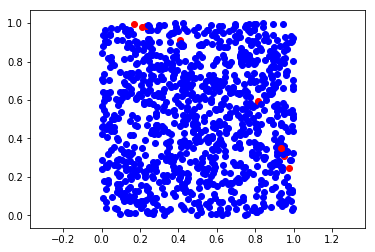

In [25]:
import matplotlib.pyplot as plt
for idx,point in enumerate(test_input):
    Col = 'b'* ( test_target[idx].dot(Prediction[idx]) > 0) + 'r' *( test_target[idx].dot(Prediction[idx]) <= 0)
    plt.scatter(point[0],point[1], color = Col)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axis('equal')
plt.show()

# Using Pytorch packages

Because of wierd reasons, if you run the same model (we call it $\texttt{pyModel}$) of the network, pytorch interprete some stuff as Variable and you can't run the our own-made model. just shutdown the notebook and start again!

In [35]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch.autograd import Variable
from random import randint
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
#seq = [Linear(2,10),'sig',Linear(10,20),'relu',Linear(20,10),'relu',Linear(10,2),'tanh']     
pyModel = nn.Sequential(nn.Linear(2,10),nn.Sigmoid(),nn.Linear(10,20),nn.ReLU(),nn.Linear(20,10),nn.ReLU(),nn.Linear(10,2),nn.Tanh())

train_input_py = Variable(train_input)
train_target_py= Variable(train_target)
test_input_py  = Variable(test_input)
test_target_py = Variable(test_target)


In [37]:
### train the model
epoch = 10000
criterion = nn.MSELoss()
optimizer = optim.SGD(pyModel.parameters(),lr = 0.3)
for e in range(epoch):
    output = pyModel(train_input_py)
    loss = criterion(output,train_target_py)
    pyModel.zero_grad()
    loss.backward()
    optimizer.step()

KeyboardInterrupt: 

In [ ]:
# Testing the model
Prediction = pyModel(test_input_py)
error(Prediction.data, test_target_py.data)

In [ ]:
for idx,point in enumerate(test_input):
    Col = 'b'* ( test_target[idx].dot(Prediction.data[idx]) > 0) + 'r' *( test_target[idx].dot(Prediction.data[idx]) <= 0)
    plt.scatter(point[0],point[1], color = Col)

plt.xlim(0,1)
plt.ylim(0,1)
plt.axis('equal')
plt.show()

# Final notes:
ما الان دو تا تابع لاس داریم. یکی بر پایه ی ترشهولد و دیگری بر پایه ی ایپاک. من برای مقایسه با پای تورچ این ایپاک دار رو اضافه کردم. باید تصمیم بگیریم که کدوم رو نگه داریم. نظر من روی ایپاک داره. چون میتونیم دوباره اجراش کنیم و حتی عدد ایپاک رو هم عوض کنیم. ولی وقتی ترشهولد گذاشتیم باید اونقدری صبر کنیم که برنامه برسه به ترشهولد... وگرنه نمی ایسته برنامه...